#Commodity Price Prediction Colab
For-fun colab to predict commodity prices using past data with ML applications.

In [1]:
# Computation imports
import pandas as pd
from pandas_datareader import data as pdr

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from datetime import datetime

# yahoo finance
import yfinance as yf

## Agriculture Commodities

### Soybean Prices

Using LSTM to predict soy prices from Yahoo Finance data and Weather data from the soybelt state (Illinois).

In [2]:
# Loading soy data
today = datetime.today().strftime('%Y-%m-%d')
soy_df = yf.download("ZS=F", start="2015-01-01", end=today)

# Keep only the close price and change df structure
soy_df = pd.DataFrame(soy_df['Close'])
soy_df.columns = ['Soy_Price']
soy_df = soy_df.reset_index()
soy_df['Date'] = pd.to_datetime(soy_df['Date'])

soy_df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Date,Soy_Price
0,2015-01-02,1002.50
1,2015-01-05,1039.75
2,2015-01-06,1051.00
3,2015-01-07,1052.75
4,2015-01-08,1045.00


In [3]:
# Coordinates for Illinois
latitude, longitude = 40.0, -89.0

# Retrieving weather from Open-Meteo API
weather_url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date=2015-01-01&end_date={today}&daily=temperature_2m_max,precipitation_sum&timezone=America%2FChicago"
weather_json = pd.read_json(weather_url)

weather_df = pd.DataFrame(weather_json['daily']['time'], columns=['Date'])
weather_df['Temp_Max'] = weather_json['daily']['temperature_2m_max']
weather_df['Precip'] = weather_json['daily']['precipitation_sum']
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df.set_index('Date', inplace=True)

# Merge weather data with soy data
data = soy_df.join(weather_df, on='Date', how='inner')
data.head()


,Date,Soy_Price,Temp_Max,Precip
0,2015-01-02,1002.50,3.4,0.0
1,2015-01-05,1039.75,-8.5,3.0
2,2015-01-06,1051.00,-7.1,0.3
3,2015-01-07,1052.75,-10.5,0.0
4,2015-01-08,1045.00,-3.3,0.0


In [4]:
# Get features
features = ['Soy_Price', 'Temp_Max', 'Precip']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Sequences of 30 Days
def create_sequences_multivariate(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0]) # for soy price only
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X, y = create_sequences_multivariate(scaled_data, SEQ_LENGTH)

# Split data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(LSTM(64, input_shape=(SEQ_LENGTH, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

y_pred_scaled = model.predict(X_test)

# Recreate full-scale prices
soy_price_scaler = MinMaxScaler()
soy_price_scaler.min_, soy_price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
y_pred = soy_price_scaler.inverse_transform(y_pred_scaled)
y_test_actual = soy_price_scaler.inverse_transform(y_test.reshape(-1, 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0467 - val_loss: 0.0024
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.6789e-04 - val_loss: 0.0021
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.7603e-04 - val_loss: 0.0020
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.6784e-04 - val_loss: 0.0019
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.8303e-04 - val_loss: 0.0019
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.4351e-04 - val_loss: 0.0021
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.9443e-04 - val_loss: 0.0025
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.1406e-04 - val_loss: 0.0020
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.7591e-04 - val_loss: 0.0018
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.0136e-04 - val_loss: 0.0020
Epoch 12/20
59/59 ━━━━━━━━━

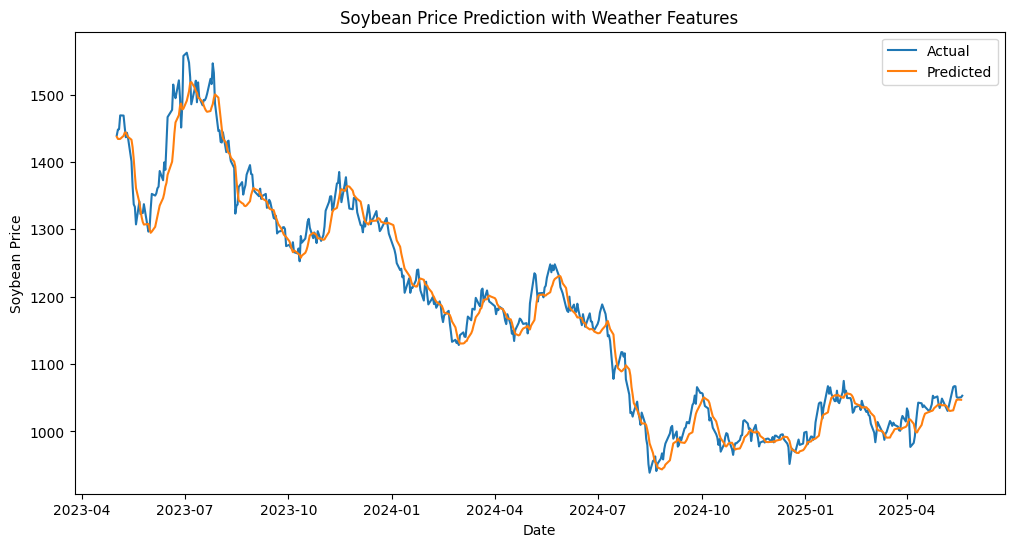

In [5]:
# Plotting prices
test_dates = data['Date'][split + SEQ_LENGTH:].reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted')
plt.title('Soybean Price Prediction with Weather Features')
plt.xlabel('Date')
plt.ylabel('Soybean Price')
plt.legend()
plt.show()

 Day Predicted Price
   1         1062.28
   2         1064.91
   3         1067.07
   4         1069.26
   5         1071.64
   6         1074.24
   7         1077.04
   8         1080.09
   9         1083.21
  10         1086.33


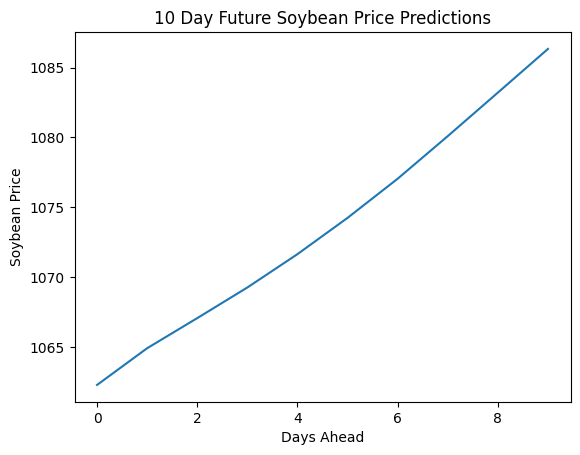

In [6]:
def predict_future_prices(model, scaled_data, scaler, seq_length=30, future_days=30):
  # Prepare last known sequence
  last_sequence = scaled_data[-seq_length:]
  current_sequence = np.expand_dims(last_sequence, axis=0)

  future_predictions_scaled = []

  for _ in range(future_days):
      next_price_scaled = model.predict(current_sequence, verbose=0)[0][0]
      future_predictions_scaled.append(next_price_scaled)

      next_day_features = current_sequence[0, -1].copy()
      next_day_features[0] = next_price_scaled  # Replace only Soy_Price

      current_sequence = np.append(current_sequence[:, 1:, :], [[next_day_features]], axis=1)

  # Use the soy_price_scaler (fitted on actual Soy_Price data)
  future_predictions = soy_price_scaler.inverse_transform(
      np.array(future_predictions_scaled).reshape(-1, 1)
  )

  return future_predictions

soy_price_scaler = MinMaxScaler()
soy_price_scaler.fit(data[['Soy_Price']])

scaled_data = np.nan_to_num(scaled_data)

future_predictions = predict_future_prices(
    model=model,
    scaled_data=scaled_data,
    scaler=soy_price_scaler,
    seq_length=10,
    future_days=10
)

# Printing predicted prices
days = range(1, len(future_predictions) + 1)
predictions_table = pd.DataFrame({
    'Day': days,
    'Predicted Price': future_predictions.flatten()
})
predictions_table['Predicted Price'] = predictions_table['Predicted Price'].apply(lambda x: f"{x:.2f}")
print(predictions_table.to_string(index=False))

# Plotting predicted prices
plt.plot(future_predictions)
plt.title("10 Day Future Soybean Price Predictions")
plt.xlabel("Days Ahead")
plt.ylabel("Soybean Price")
plt.show()

### Wheat Prices

In [7]:
# Load wheat data
wheat_df = yf.download("ZW=F", start="2015-01-01", end=today)

# Keep only the close price and change df structure
wheat_df = pd.DataFrame(wheat_df['Close'])
wheat_df.columns = ['Wheat_Price']
wheat_df = wheat_df.reset_index()
wheat_df['Date'] = pd.to_datetime(wheat_df['Date'])

wheat_df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Wheat_Price
0,2015-01-02,581.25
1,2015-01-05,589.00
2,2015-01-06,591.75
3,2015-01-07,579.50
4,2015-01-08,567.00


In [8]:
# Economic factors to account for
interest = pdr.DataReader("FEDFUNDS", "fred", '2015-01-01', today)

# Merge to daily using forward-fill
econ = pd.DataFrame(interest)
econ.columns = ['Interest_Rate']
econ = econ.resample('D').ffill()

# Merge all data
data = pd.merge(wheat_df, econ, left_on='Date', right_index=True, how='inner')
data = data.dropna()

In [9]:
features = ['Wheat_Price', 'Interest_Rate']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Create sequences
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X, y = create_sequences(scaled_data, SEQ_LENGTH)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(LSTM(64, input_shape=(SEQ_LENGTH, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

y_pred_scaled = model.predict(X_test)

# Inverse transform only wheat price
wheat_scaler = MinMaxScaler()
wheat_scaler.min_, wheat_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

y_pred = wheat_scaler.inverse_transform(y_pred_scaled)
y_test_actual = wheat_scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0079 - val_loss: 0.0042
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.2313e-04 - val_loss: 0.0027
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.2375e-04 - val_loss: 0.0031
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2053e-04 - val_loss: 0.0010
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.3319e-04 - val_loss: 0.0012
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.2934e-04 - val_loss: 0.0010
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.1282e-04 - val_loss: 9.3343e-04
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.5723e-04 - val_loss: 7.7540e-04
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6610e-04 - val_loss: 0.0011
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.0800e-04 - val_loss: 7.2168e-04
Epoch 11/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.9247e-04 - val_loss: 6.8612e-04
Epoch 12/20
58/58 

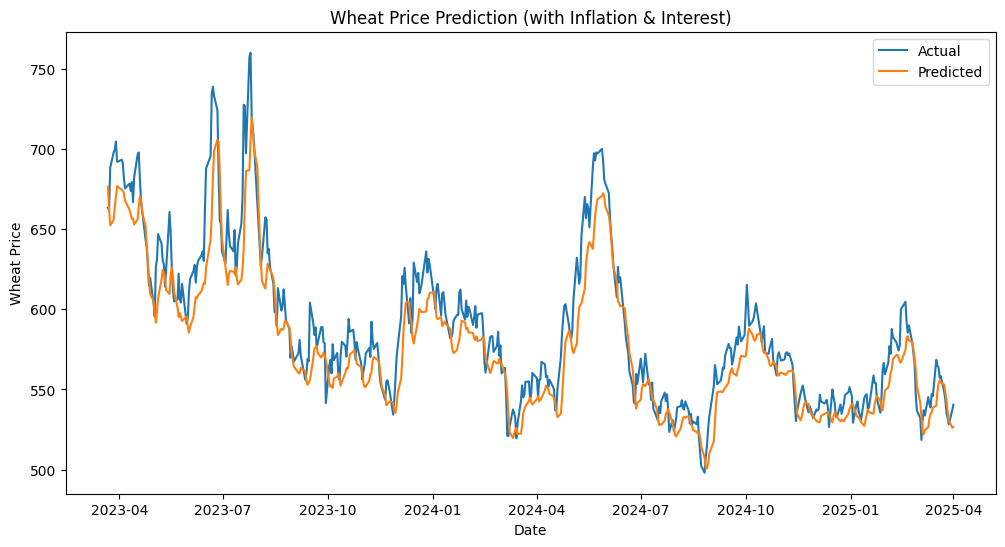

In [10]:
test_dates = data['Date'][split + SEQ_LENGTH:].reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted')
plt.title('Wheat Price Prediction (with Inflation & Interest)')
plt.xlabel('Date')
plt.ylabel('Wheat Price')
plt.legend()
plt.show()

Day 1: 529.08
Day 2: 529.33
Day 3: 529.97
Day 4: 530.39
Day 5: 530.49
Day 6: 530.18
Day 7: 529.45
Day 8: 528.32
Day 9: 526.84
Day 10: 525.06


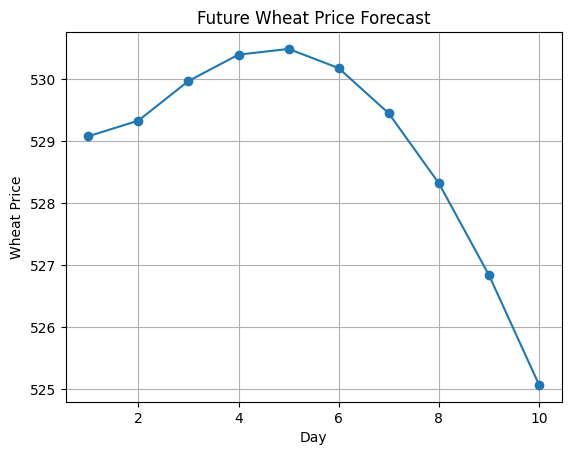

In [11]:
def predict_future_prices(model, scaler, last_sequence, future_interest_rates, n_days):
  future_predictions = []

  current_sequence = last_sequence.copy()

  for i in range(n_days):
      input_seq = current_sequence.reshape(1, SEQ_LENGTH, 2)
      next_scaled_price = model.predict(input_seq, verbose=0)[0][0]

      future_predictions.append(next_scaled_price)

      next_interest = future_interest_rates[i]

      interest_scaled = (next_interest - scaler.data_min_[1]) / (scaler.data_max_[1] - scaler.data_min_[1])

      next_day = [next_scaled_price, interest_scaled]
      current_sequence = np.vstack([current_sequence[1:], next_day])

  padded = np.hstack([np.array(future_predictions).reshape(-1, 1), np.zeros((n_days, 1))])
  wheat_pred = scaler.inverse_transform(padded)[:, 0]

  return wheat_pred

last_sequence = scaled_data[-SEQ_LENGTH:]
future_interest_rates = [5.25]*10

future_prices = predict_future_prices(model, scaler, last_sequence, future_interest_rates, n_days=10)

for i, price in enumerate(future_prices, 1):
    print(f"Day {i}: {price:.2f}")

plt.plot(range(1, 11), future_prices, marker='o')
plt.title('Future Wheat Price Forecast')
plt.xlabel('Day')
plt.ylabel('Wheat Price')
plt.grid(True)
plt.show()


## Energy Commodities

### Crude Oil Prices

In [12]:
oil_df = yf.download("CL=F", start="2015-01-01", end=today)

oil_df = pd.DataFrame(oil_df['Close'])
oil_df.columns = ['Oil_Price']
oil_df = oil_df.reset_index()
oil_df['Date'] = pd.to_datetime(oil_df['Date'])

oil_df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Oil_Price
0,2015-01-02,52.689999
1,2015-01-05,50.040001
2,2015-01-06,47.930000
3,2015-01-07,48.650002
4,2015-01-08,48.790001


In [13]:
# Additional data to merge
'''
  Natural Gas:	NG=F
  S&P 500 Index: ^GSPC
  US Dollar Index: DX-Y.NYB
  Energy Sector ETF: XLE
  Brent Crude: BZ=F
'''
tickers = ['CL=F', 'NG=F', '^GSPC', 'DX-Y.NYB', 'XLE', 'BZ=F']
data = yf.download(tickers, start='2010-01-01', end=today)['Close']
data.dropna(inplace=True)

trend_data = data.pct_change(periods=7)
trend_data.columns = [f"{col}_trend" for col in trend_data.columns]
trend_data.dropna(inplace=True)

# Merge with crude oil data
oil_df = data[['CL=F']].copy()
oil_df.rename(columns={'CL=F': 'Close'}, inplace=True)

oil_merge_df = oil_df.join(trend_data)
oil_merge_df.dropna(inplace=True)

[*********************100%***********************]  6 of 6 completed


In [14]:
features = oil_merge_df.values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(features)

# Create sequences
def create_sequences_multi(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences_multi(scaled, seq_len)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)

y_test_unscaled = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1,1), X_test[:, -1, 1:]], axis=1)
)[:,0]

y_pred_unscaled = scaler.inverse_transform(
    np.concatenate([y_pred, X_test[:, -1, 1:]], axis=1)
)[:,0]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 0.0548 - val_loss: 0.0021
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0055 - val_loss: 0.0010
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 0.0033 - val_loss: 5.3159e-04
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0025 - val_loss: 7.6573e-04
Epoch 10/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 11/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0025 - val_loss: 5.9556e-04
Epoch 12/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms

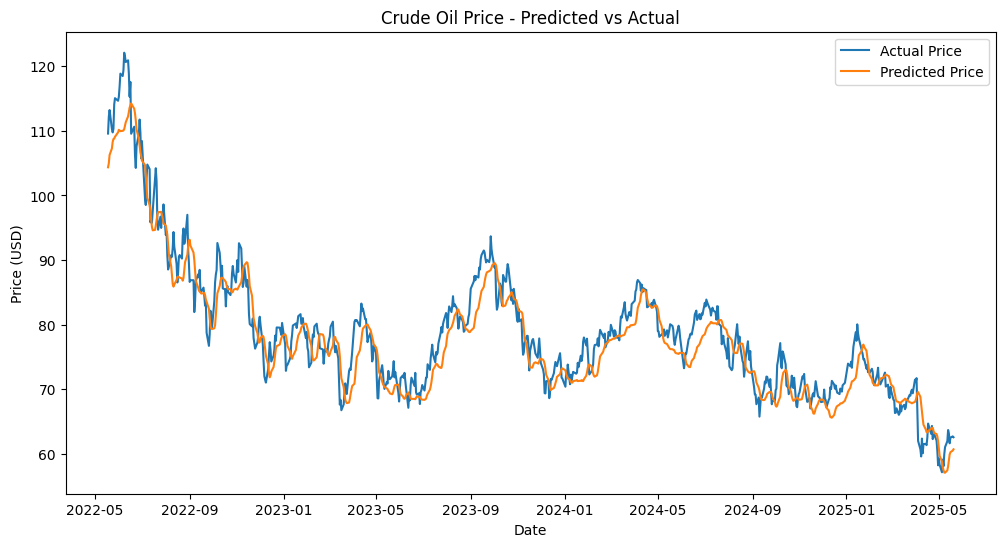

In [15]:
test_dates_oil = oil_merge_df.index[split + seq_len:]

plt.figure(figsize=(12,6))
plt.plot(test_dates_oil, y_test_unscaled, label='Actual Price')
plt.plot(test_dates_oil, y_pred_unscaled, label='Predicted Price')
plt.title("Crude Oil Price - Predicted vs Actual")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


Predicted Crude Oil Prices for the next 10 days:
Day 1: 60.57
Day 2: 60.25
Day 3: 59.84
Day 4: 59.42
Day 5: 59.01
Day 6: 58.63
Day 7: 58.29
Day 8: 57.98
Day 9: 57.70
Day 10: 57.44


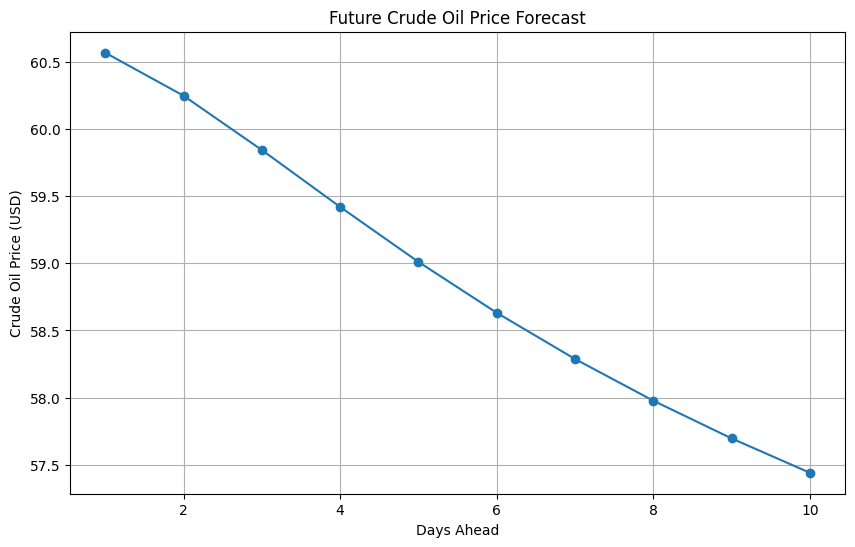

In [16]:
def predict_future_oil_prices(model, scaler, last_sequence, n_days):
  future_predictions_scaled = []
  current_sequence = last_sequence.copy()

  for _ in range(n_days):
      input_sequence = current_sequence.reshape(1, seq_len, features.shape[1])
      next_scaled_price = model.predict(input_sequence, verbose=0)[0][0]
      future_predictions_scaled.append(next_scaled_price)

      next_day_features = current_sequence[-1, :].copy()
      next_day_features[0] = next_scaled_price
      current_sequence = np.vstack([current_sequence[1:, :], next_day_features])

  dummy_features = np.zeros((n_days, features.shape[1]))
  dummy_features[:, 0] = np.array(future_predictions_scaled).flatten()

  future_predictions_unscaled = scaler.inverse_transform(dummy_features)[:, 0]

  return future_predictions_unscaled

last_sequence = scaled[-seq_len:]

future_oil_predictions = predict_future_oil_prices(model, scaler, last_sequence, n_days=10)

print("\nPredicted Crude Oil Prices for the next 10 days:")
for i, price in enumerate(future_oil_predictions, 1):
    print(f"Day {i}: {price:.2f}")

# Plot the predicted future prices
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(future_oil_predictions) + 1), future_oil_predictions, marker='o', linestyle='-')
plt.title('Future Crude Oil Price Forecast')
plt.xlabel('Days Ahead')
plt.ylabel('Crude Oil Price (USD)')
plt.grid(True)
plt.show()

## Metals Commodities

### Gold Prices

In [17]:
gold_df = yf.download("GC=F", start="2015-01-01", end=today)

gold_df = pd.DataFrame(gold_df['Close'])
gold_df.columns = ['Gold_Price']
gold_df = gold_df.reset_index()
gold_df['Date'] = pd.to_datetime(gold_df['Date'])

gold_df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Gold_Price
0,2015-01-02,1186.000000
1,2015-01-05,1203.900024
2,2015-01-06,1219.300049
3,2015-01-07,1210.599976
4,2015-01-08,1208.400024


In [18]:
scaler = MinMaxScaler()
gold_df['Scaled_Price'] = scaler.fit_transform(gold_df[['Gold_Price']])

def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(gold_df['Scaled_Price'].values, window_size)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = Sequential([
    Dense(64, activation='relu', input_shape=(window_size,)),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

predicted = model.predict(X_test)

predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0126 - val_loss: 3.6709e-04
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5249e-04 - val_loss: 2.9180e-04
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2210e-04 - val_loss: 2.3714e-04
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0299e-04 - val_loss: 1.9620e-04
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.0955e-05 - val_loss: 1.4853e-04
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.6875e-05 - val_loss: 1.3300e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.8129e-05 - val_loss: 1.8710e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8052e-05 - val_loss: 1.3020e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5948e-05 - val_loss: 9.6247e-05
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4202e-05 - val_loss: 8.0150e-05
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9176e-05 - val_loss: 7.7393e-05
E

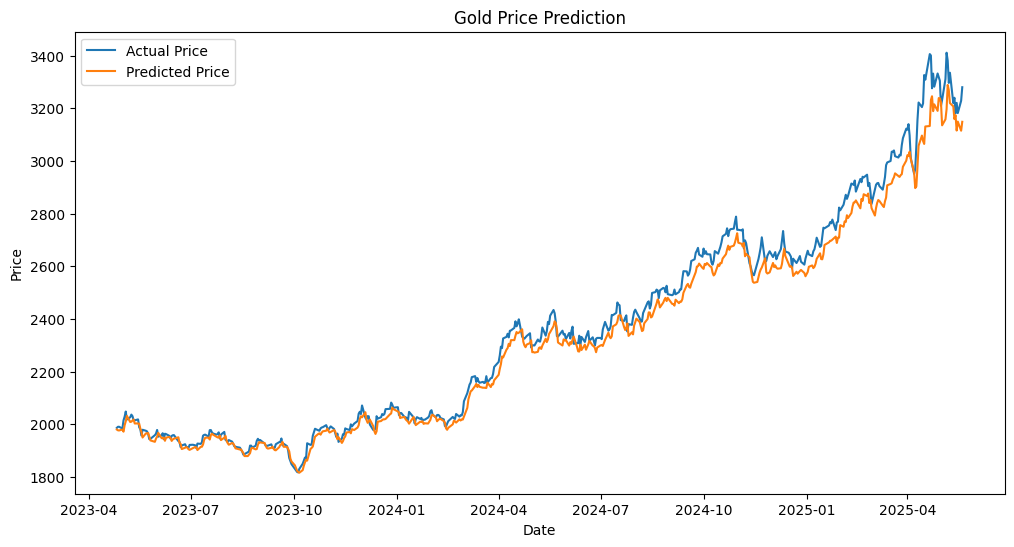

In [19]:
test_dates = gold_df['Date'].iloc[len(X_train) + window_size:].reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_prices, label='Actual Price')
plt.plot(test_dates, predicted_prices, label='Predicted Price')

plt.title('Gold Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Day 1: 3154.26
Day 2: 3103.05
Day 3: 3040.85
Day 4: 2981.97
Day 5: 2958.85
Day 6: 2936.77
Day 7: 2899.18
Day 8: 2862.45
Day 9: 2834.82
Day 10: 2802.83


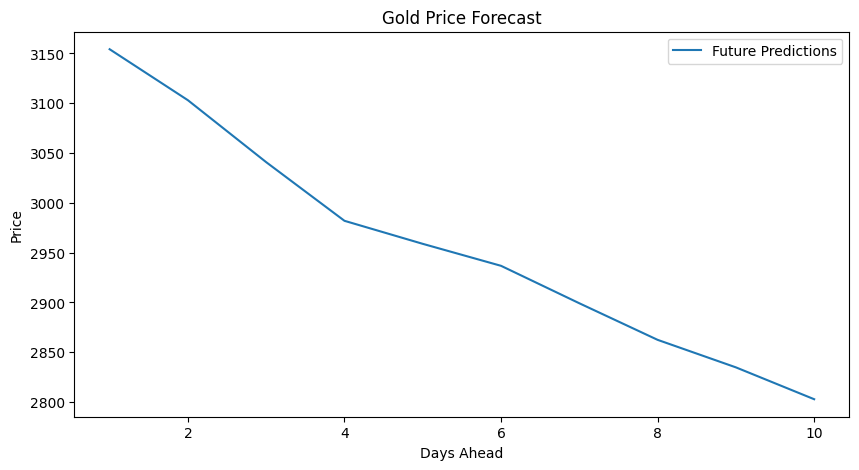

In [20]:
def predict_future_prices(model, last_sequence, n_days, scaler):
  future_predictions = []
  current_input = last_sequence.copy()

  for _ in range(n_days):
      # Reshape current_input to (1, window_size)
      prediction = model.predict(current_input.reshape(1, -1))[0][0]
      future_predictions.append(prediction)
      current_input = np.append(current_input[1:], prediction)

  predicted_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
  return predicted_prices

last_sequence = gold_df['Scaled_Price'].values[-window_size:]
future_prices = predict_future_prices(model, last_sequence, n_days=10, scaler=scaler)

for i, price in enumerate(future_prices, 1):
    print(f"Day {i}: {price[0]:.2f}")


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(future_prices) + 1), future_prices, label='Future Predictions')
plt.title("Gold Price Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Price")
plt.legend()
plt.show()